In [0]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


import matplotlib.pyplot as plt
%matplotlib inline

##导入文件：
因为colab上传的文件在每一次重新连接之后都会被情况，因此这里采用了从google drive 上导入文件的方法。使用了python的PyDrive包以及google对应的SDK 使得colab笔记本可以使用储存在google drive上的文件；第一次运行GoogleAuth的时候会鉴权

In [0]:
# 安装 PyDrive 操作库，该操作每个 notebook 只需要执行一次
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 授权登录，仅第一次的时候会鉴权
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

##导入并处理数据
使用google drive之后可以获取每个文件的id（此处略过），通过该id可以把对应文件缓存到笔记本的当前目录下进行使用。之后可以使用pandas库读取csv文件，保存成为dataframe的格式。
##数据清洗
对数据进行预览后可以发现，数据中存在许多缺失和异常值。这里以预测一氧化碳为例。首先去除掉值全为nan的行。之后经过观察，发现CO(GT)和T两列中存在着大量值为-200的项，显然是一场值，于是仅保留大于0的值


In [0]:
file = drive.CreateFile({'id': "1oBAq3B6MM1yyM35qn-JypNZVXCnR5e7v"}) 
file.GetContentFile('AirQualityUCI.csv', "text/csv") 
df=pd.read_csv('AirQualityUCI.csv',sep=';',skiprows=0)
df=df.iloc[:,:15]
df=df.dropna(axis=0,how='any')
df = df.replace(',','.',regex=True)
df.iloc[:,2:] = df.iloc[:,2:].astype('float64')
df = df[(df['T']>0)][(df['CO(GT)']>0)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


##数据集划分
首先选取了原dataframe中对应的列分别作为数据和标签；然后调用sklearn中的train_test_split函数划分测试集。这里采用了30%的数据作为测试集，同时，为了保证结果的可复现性，固定选取了0作为随机因子
##标准化
为了消除数据绝对值大小对结果带来的影响，对训练数据进行了标准化操作

In [0]:
data = df.iloc[:,[3,12,13]]
label = df['CO(GT)']
x_train,x_test,y_train,y_test = train_test_split(data,label,test_size=0.3,random_state=0)
sc = StandardScaler()
sc.fit(x_train)
x_train_std = sc.transform(x_train)
x_test_std = sc.transform(x_test)

##模型训练
这里采用了sklearn中的线性回归模型，并选取了默认的L2范数作为度量标准
##模型检验
通过计算预测值和实际值的均方误差来检验模型的效果

In [0]:
log = LinearRegression()
log.fit(x_train_std,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [0]:
y_pred=log.predict(x_test_std)
mean_squared_error(y_test, y_pred)

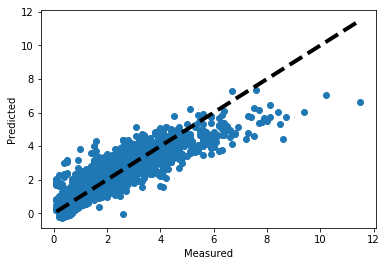

In [0]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()